In [1]:
import os
import sys
import random

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Check versions of libraries
print(f"Python: {sys.version}")
print(f"numpy: {np.__version__}")
print(f"tensorflow: {tf.__version__}")

print(tf.config.list_physical_devices("GPU"))

Python: 3.8.10 (default, May 19 2021, 18:05:58) 
[GCC 7.3.0]
numpy: 1.19.5
tensorflow: 2.5.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
CURRENT_DIR = os.getcwd()
TRAINING_SET_DIR = os.path.join(CURRENT_DIR, "images", "training_set")
VALIDATION_SET_DIR = os.path.join(CURRENT_DIR, "images", "validation_set")

EPOCHS = 15
BATCH_SIZE = 24
NUMBER_OF_TRAINING_IMAGES = 0
NUMBER_OF_VALIDATION_IMAGES = 0

# Must be the same input size as the base model
# Currently using: EfficientNetB5 - (456, 456)
IMAGE_WIDTH = 456
IMAGE_HEIGHT = 456

In [3]:
image_generator_train = keras.preprocessing.image.ImageDataGenerator(
    # rescale=1./255,
    brightness_range=[0.4, 1.4],
    channel_shift_range=30,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=5,
    zoom_range=0.1,
    horizontal_flip=True,
)

data_generator_train = image_generator_train.flow_from_directory(
    batch_size=BATCH_SIZE,
    directory=TRAINING_SET_DIR,
    shuffle=True,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="categorical"
)

image_generator_validation = keras.preprocessing.image.ImageDataGenerator(
    # rescale=1./255
)

data_generator_validation = image_generator_validation.flow_from_directory(
    batch_size=BATCH_SIZE,
    directory=VALIDATION_SET_DIR,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="categorical"
)

NUMBER_OF_TRAINING_IMAGES = data_generator_train.samples
NUMBER_OF_VALIDATION_IMAGES = data_generator_validation.samples

sample_images_train, _ = next(data_generator_train)

Found 65228 images belonging to 130 classes.
Found 5200 images belonging to 130 classes.


In [4]:
def image_view(images, rows, columns):
    """Displays the first NxM images in a NxM subplot"""

    fig, ax = plt.subplots(rows, columns, figsize=(8, 8))
    image_index = 0

    for i in range(rows):
        for j in range(columns):
            ax[i, j].imshow(images[image_index].astype("uint8"))
            ax[i, j].axis("off")
            image_index += 1

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.tight_layout()
    plt.show()

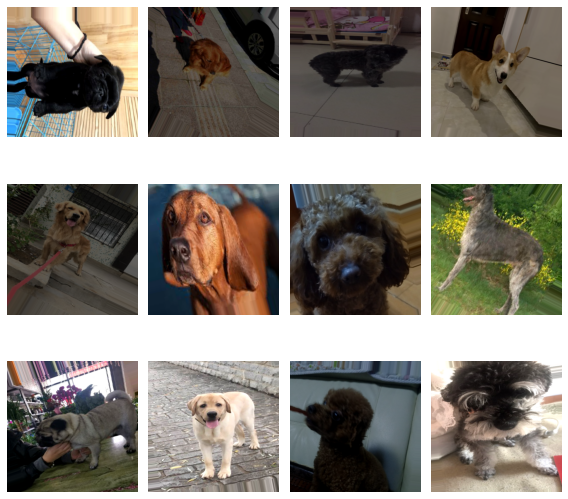

In [5]:
image_view(sample_images_train, 3, 4)

In [6]:
base_model = keras.applications.EfficientNetB5(
    weights="imagenet", include_top=False, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)
)

inputs = keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
x = tf.cast(inputs, dtype=tf.uint8)
x = base_model(x, training=False)

"""Global average pooling as classifier
Section 3.2: https://arxiv.org/pdf/1312.4400.pdf
Test1: learning_rate = 0.001, batchsize = 24, epochs = 5; brackets indicate loss
       80% (0.68), 84% (0.484), 85% (0.438), 86% (0.407), 86.88% (0.381)
"""
# x = keras.layers.GlobalAveragePooling2D()(x)

x = keras.layers.MaxPooling2D((2, 2))(x)
x = keras.layers.Flatten()(x)
# x = keras.layers.Dropout(0.2)(x)

# 1024 or greater is too many parameters, 512 is 26214912 parameters
x = keras.layers.Dense(512, activation="relu")(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(256, activation="relu")(x)
x = keras.layers.Dropout(0.2)(x)

outputs = keras.layers.Dense(130, activation="softmax")(x)
model = keras.models.Model(inputs=inputs, outputs=outputs)

for layer in base_model.layers:
    layer.trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 456, 456, 3)]     0         
_________________________________________________________________
tf.cast (TFOpLambda)         (None, 456, 456, 3)       0         
_________________________________________________________________
efficientnetb5 (Functional)  (None, 15, 15, 2048)      28513527  
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 2048)        0         
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               51380736  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0     

In [7]:
history = model.fit(
    data_generator_train,
    epochs=EPOCHS,
    steps_per_epoch=NUMBER_OF_TRAINING_IMAGES // BATCH_SIZE,
    validation_data=data_generator_validation,
    validation_steps=NUMBER_OF_VALIDATION_IMAGES // BATCH_SIZE
)

Epoch 1/15
2717/2717 [==============================] - 2269s 832ms/step - loss: 2.1696 - accuracy: 0.5207 - val_loss: 1.6338 - val_accuracy: 0.5623
Epoch 2/15
2717/2717 [==============================] - 2271s 836ms/step - loss: 1.5172 - accuracy: 0.6130 - val_loss: 1.4931 - val_accuracy: 0.5600
Epoch 3/15
2717/2717 [==============================] - 2238s 824ms/step - loss: 1.4882 - accuracy: 0.6225 - val_loss: 1.4675 - val_accuracy: 0.5702
Epoch 4/15
2717/2717 [==============================] - 2196s 808ms/step - loss: 1.4599 - accuracy: 0.6339 - val_loss: 1.4997 - val_accuracy: 0.5762
Epoch 5/15
2717/2717 [==============================] - 2191s 806ms/step - loss: 1.4826 - accuracy: 0.6359 - val_loss: 1.4395 - val_accuracy: 0.6113
Epoch 6/15
2717/2717 [==============================] - 2188s 805ms/step - loss: 1.5339 - accuracy: 0.6338 - val_loss: 1.6617 - val_accuracy: 0.5889
Epoch 7/15
2717/2717 [==============================] - 2190s 806ms/step - loss: 1.4934 - accuracy: 0.6359

In [8]:
# model.summary()
model.save("EfficientNetB5Model")

# loaded_model = keras.models.load_model(os.path.join(CURRENT_DIR, "model"))
# loaded_model.summary()

/home/colton-ubuntu/anaconda3/envs/tensorflow/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: EfficientNetB5Model/assets


In [9]:
accuracy = history.history["accuracy"]
validation_accuracy = history.history["val_accuracy"]

loss = history.history["loss"]
validation_loss = history.history["val_loss"]

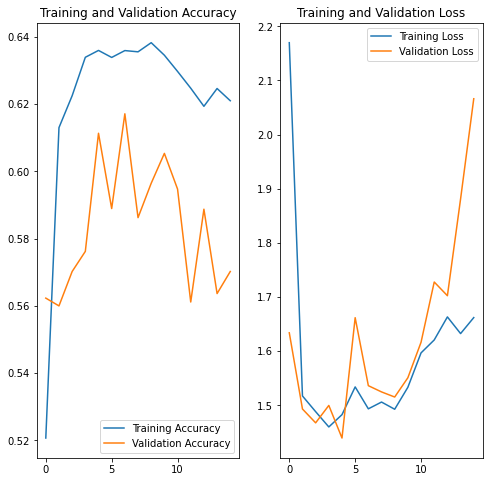

In [10]:
"""Plot accuracy of model by epochs"""
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), accuracy, label="Training Accuracy")
plt.plot(range(EPOCHS), validation_accuracy, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

"""Plot loss of model by epochs"""
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label="Training Loss")
plt.plot(range(EPOCHS), validation_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

In [11]:
"""Testing the model with an image"""
"""
class_names = np.array([
    name[0] for name in sorted(data_generator_train.class_indices.items())
])

image_dir = os.path.join("/home/kenroku/Code/DogID/images/training_set/malamute-n000004", "n103348.jpg")

image = keras.preprocessing.image.load_img(image_dir, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
image_tensor = keras.preprocessing.image.img_to_array(image)
image_tensor = np.expand_dims(image_tensor, axis=0)
image_tensor = image_tensor / 255

predictions = loaded_model.predict(image_tensor)

# Get top 1 prediction
predicted_classes = class_names[np.argmax(predictions, axis=-1)]
print("Top prediction:", predicted_classes)

# Get top 5 predictions
print("Top 5 choices:")
prediction_probabilities = np.argsort(predictions, axis=-1)[0][::-1][:5]
for choice, names in enumerate(prediction_probabilities):
    print(str(choice + 1) + ") " + class_names[names])

"""

'\nclass_names = np.array([\n    name[0] for name in sorted(data_generator_train.class_indices.items())\n])\n\nimage_dir = os.path.join("/home/kenroku/Code/DogID/images/training_set/malamute-n000004", "n103348.jpg")\n\nimage = keras.preprocessing.image.load_img(image_dir, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))\nimage_tensor = keras.preprocessing.image.img_to_array(image)\nimage_tensor = np.expand_dims(image_tensor, axis=0)\nimage_tensor = image_tensor / 255\n\npredictions = loaded_model.predict(image_tensor)\n\n# Get top 1 prediction\npredicted_classes = class_names[np.argmax(predictions, axis=-1)]\nprint("Top prediction:", predicted_classes)\n\n# Get top 5 predictions\nprint("Top 5 choices:")\nprediction_probabilities = np.argsort(predictions, axis=-1)[0][::-1][:5]\nfor choice, names in enumerate(prediction_probabilities):\n    print(str(choice + 1) + ") " + class_names[names])\n\n'